# Ejercicio Caso 1
## Cada vehiculo con su propia capacidad

### Integrantes:
- David Betancur
- Daniel Salazar
- Pablo García

### Problema:
Una empresa de entregas debe optimizar las rutas de sus vehículos para entregar paquetes a una serie de clientes distribuidos en una ciudad. El objetivo es minimizar la distancia total recorrida por todos los vehículos, respetando las restricciones de capacidad de los vehículos y asegurando que todas las entregas se completen de manera eficiente.

#### Detalles del Problema:
- **Clientes:**
Hay n clientes, cada uno con una ubicación específica representada por coordenadas (x, y)
en un plano 2D.
Cada cliente tiene una demanda de entrega, que representa la cantidad de paquetes que
necesita recibir.
- **Depósito:**
Hay un único depósito donde todos los vehículos inician y terminan su recorrido.
- **Vehículos:**
La empresa cuenta con m vehículos, cada uno con una capacidad máxima de carga.
Los vehículos deben comenzar y terminar su ruta en el depósito.
- **Distancia:**
La distancia entre dos puntos (ya sea entre dos clientes o entre un cliente y el depósito) se
calcula utilizando la distancia euclidiana.
- **Ruta:**
Cada vehículo sigue una ruta que comienza y termina en el depósito, visitando un conjunto
de clientes de manera que la demanda total de los clientes en la ruta no exceda la capacidad
del vehículo.
- **Restricciones:**
Cada cliente debe ser visitado exactamente una vez por uno de los vehículos.
La capacidad de cada vehículo no debe ser excedida.

#### Objetivo:
Minimizar la distancia total recorrida por todos los vehículos.

#### Entrega:
Una presentación de no más de 10 minutos donde expongan la descripción del problema, el detalle
de la función de adaptabilidad y la interpretación del resultado.

# Importar librerías

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools, algorithms
import math

#Advertencias
import warnings
warnings.filterwarnings('ignore')

## Stats

In [44]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('Promedio', np.mean)
stats.register('Desviación Estándar', np.std)
stats.register('Mínimo', np.min)
stats.register('Máximo', np.max)

## Configuración de parámetros inicales que se utilizan después cuando se llama al método

In [45]:
MAX_CLIENTES = 20                 # Número maximo de clientes
MIN_DEMANDA_CLIENTE = 1           # Demanda mínima de cada cliente
MAX_DEMANDA_CLIENTE = 20          # Demanda máxima de cada cliente

MAX_VEHICULOS = 5                 # Número maximo de vehículos
MIN_CAPACIDAD_VEHICULO = 40       # Capacidad mínima de cada vehículo
MAX_CAPACIDAD_VEHICULO = 80      # Capacidad máxima de cada vehículo

TAMANO_POBLACION = 500            # Tamaño de la población
MAX_GENERACIONES = 800            # Número máximo de generaciones
PROBABILIDAD_CRUCE = 0.9          # Probabilidad de cruce
PROBABILIDAD_MUTACION = 0.05       # Probabilidad de mutación

TAMANO_MAPA = 100                 # Tamaño del mapa

In [46]:
# Número de vehiculos
NUM_VEHICULOS = random.randint(3, MAX_VEHICULOS)

# Número de clientes
NUM_CLIENTES = random.randint(NUM_VEHICULOS, MAX_CLIENTES)

## Clases para representar a los Clientes, el Depósito y los Vehículos

In [47]:
# Clase para representar un cliente
class Cliente:
  def __init__(self, id, x, y, demanda):
    self.id = id
    self.x = x
    self.y = y
    self.demanda = demanda

  def __str__(self):
    return f"Cliente(id={self.id}, x={self.x}, y={self.y}, demanda={self.demanda})"

# Clase para representar el depósito
class Deposito:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.id = 0

  def __str__(self):
    return f"Deposito(id={self.id}, x={self.x}, y={self.y})"

# Clase para representar un vehículo
class Vehiculo:
  def __init__(self, capacidad):
    self.capacidad = capacidad
    self.carga_actual = 0
    self.ruta = []

  def __str__(self):
    return f"Vehiculo(capacidad={self.capacidad}, carga_actual={self.carga_actual}, ruta={self.ruta})"

## Función para calcular la distancia euclidiana entre dos puntos

In [48]:
def calcular_distancia(punto1, punto2):
    return math.sqrt((punto1.x - punto2.x)**2 + (punto1.y - punto2.y)**2)

## Generar ubicación de los clientes aleatoriamente

In [49]:
# Generar clientes aleatorios en el mapa
# con coordenadas (x, y) y una demanda aleatoria
def generar_clientes(num_clientes, deposito):
    clientes = []
    coordenadas_usadas = set()

    while len(clientes) < num_clientes:
        x = int(random.uniform(0, TAMANO_MAPA))
        y = int(random.uniform(0, TAMANO_MAPA))

        # Validar que el cliente no esté en la posición del depósito
        # y que no tenga las mismas coordenadas que otro cliente
        if (x, y) != (deposito.x, deposito.y) and (x, y) not in coordenadas_usadas:
            demanda = random.randint(MIN_DEMANDA_CLIENTE, MAX_DEMANDA_CLIENTE)
            cliente = Cliente(len(clientes), x, y, demanda)
            clientes.append(cliente)
            coordenadas_usadas.add((x, y))

    return clientes

In [50]:
# Generar el depósito en el centro del mapa
deposito = Deposito(TAMANO_MAPA / 2, TAMANO_MAPA / 2)

# Generar clientes aleatorios
clientes = generar_clientes(NUM_CLIENTES, deposito)

## Generar vehiculos con diferentes capacidades

In [51]:
def generar_vehiculos(num_vehiculos):
    vehiculos = []
    for _ in range(num_vehiculos):
        capacidad = random.randint(MIN_CAPACIDAD_VEHICULO, MAX_CAPACIDAD_VEHICULO)
        vehiculos.append(Vehiculo(capacidad))
    return vehiculos

In [52]:
vehiculos = generar_vehiculos(NUM_VEHICULOS)

# Verificar si la demanda total es mayor que la capacidad total
while sum(cliente.demanda for cliente in clientes) > sum(vehiculo.capacidad for vehiculo in vehiculos):
    # Generar vehiculo adicional
    vehiculo = generar_vehiculos(1)[0]
    vehiculos.append(vehiculo)

NUM_VEHICULOS = len(vehiculos)

## Declarar los artefactos genéticos

In [53]:
#Contenedor de las operaciones genéticas
toolbox = base.Toolbox()

## Creación de los individuos

In [55]:
ids_clientes = [cliente.id for cliente in clientes]

def crear_individuo():
    individuo = ids_clientes[:]
    random.shuffle(individuo)
    return individuo

## Evaluamos la aptitud de un individuo

In [56]:
def evaluar_individuo(individuo, clientes, deposito, vehiculos):
    total_distancia = 0
    cliente_index = 0
    num_clientes = len(individuo)

    for vehiculo in vehiculos:
        carga_actual = 0
        posicion_actual = deposito

        while cliente_index < num_clientes:
            cliente_id = individuo[cliente_index]
            cliente = next(c for c in clientes if c.id == cliente_id)

            # Si ya no cabe en este vehículo, se pasa al siguiente
            if carga_actual + cliente.demanda > vehiculo.capacidad:
                break

            # Ir al cliente
            total_distancia += calcular_distancia(posicion_actual, cliente)
            carga_actual += cliente.demanda
            posicion_actual = cliente
            cliente_index += 1

        # Regreso al depósito al final de la ruta
        total_distancia += calcular_distancia(posicion_actual, deposito)

    # Si aún quedan clientes sin atender, penalizamos
    if cliente_index < num_clientes:
        total_distancia += 1e6  # penalización MUY fuerte

    return (total_distancia,)

## Se define el problema como minimización

In [54]:
# Definir el problema como minimización
creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list, fitness = creator.FitnessMin)

## Registramos las funciones

In [57]:
toolbox.register("individual", tools.initIterate, creator.Individual, crear_individuo)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluar_individuo, clientes=clientes, deposito=deposito, vehiculos=vehiculos)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=PROBABILIDAD_MUTACION)
toolbox.register("select", tools.selTournament, tournsize=3)

## Creamos la población inicial

In [58]:
poblacion = toolbox.population(n=TAMANO_POBLACION)

## Ejecutamos el algoritmo tratando de obtener el mejor individuo

In [59]:
resultado, log = algorithms.eaSimple(poblacion, toolbox,
                                     cxpb=PROBABILIDAD_CRUCE,
                                     mutpb=PROBABILIDAD_MUTACION,
                                     ngen=MAX_GENERACIONES,
                                     stats=stats,
                                     verbose=True)

# Obtener el mejor individuo
mejor = tools.selBest(resultado, 1)[0]

gen	nevals	Promedio	Desviación Estándar	Mínimo 	Máximo 
0  	500   	904.611 	61.6982            	738.009	1076.24
1  	451   	882.775 	65.9303            	685.224	1067.14
2  	450   	866.198 	67.6847            	625.755	1042.35
3  	438   	857.117 	70.8308            	643.706	1094.08
4  	443   	850.798 	67.7014            	633.268	1051.17
5  	448   	844.792 	66.4621            	653.383	1049.51
6  	455   	844.932 	72.7858            	646.091	1021.92
7  	451   	836.629 	73.5674            	642.936	1024.59
8  	461   	840.546 	68.8024            	643.647	1038.16
9  	467   	835.808 	72.6947            	645.67 	1061.04
10 	446   	834.838 	71.954             	645.149	1037.67
11 	443   	839.196 	76.7222            	641.505	1094.39
12 	451   	837.327 	75.8199            	660.316	1044.54
13 	457   	833.552 	77.1988            	625.171	1052.82
14 	453   	830.738 	74.5984            	637.326	1030.44
15 	463   	833.89  	74.4103            	636.385	1055.91
16 	438   	833.828 	76.5999            	657.961	

## Proceso generacional y Visualización

### Funciones

In [60]:
def obtener_rutas_por_vehiculo(individuo, clientes, vehiculos):
    rutas = []
    cliente_index = 0
    num_clientes = len(individuo)

    for vehiculo in vehiculos:
        carga_actual = 0
        ruta_vehiculo = []
        demanda_total = 0
        distancia_total = 0
        posicion_actual = deposito

        while cliente_index < num_clientes:
            cliente_id = individuo[cliente_index]
            cliente = next(c for c in clientes if c.id == cliente_id)

            if carga_actual + cliente.demanda > vehiculo.capacidad:
                break

            # Calcular distancia al cliente
            distancia_total += calcular_distancia(posicion_actual, cliente)
            ruta_vehiculo.append(cliente_id)
            carga_actual += cliente.demanda
            demanda_total += cliente.demanda
            posicion_actual = cliente
            cliente_index += 1

        # Regresar al depósito
        distancia_total += calcular_distancia(posicion_actual, deposito)

        rutas.append({
            'vehiculo': vehiculo,
            'clientes': ruta_vehiculo,
            'demanda_total': demanda_total,
            'capacidad_total': vehiculo.capacidad,
            'distancia_total': distancia_total
        })

    # Si hay clientes sin asignar
    if cliente_index < num_clientes:
        rutas.append({
            'vehiculo': None,
            'clientes': [individuo[i] for i in range(cliente_index, num_clientes)],
            'demanda_total': None,
            'capacidad_total': None,
            'distancia_total': None
        })

    # Verificación estricta
    if cliente_index < num_clientes:
        raise ValueError(f"⚠️ Solución inválida: hay {num_clientes - cliente_index} cliente(s) no asignado(s).")

    return rutas

In [61]:
def graficar_solucion(individuo, clientes, deposito, vehiculos):
    rutas = obtener_rutas_por_vehiculo(individuo, clientes, vehiculos)
    plt.figure(figsize=(10, 8))

    # Dibujar clientes
    for cliente in clientes:
        plt.plot(cliente.x, cliente.y, 'bo')
        plt.text(cliente.x + 1, cliente.y + 1, f'C{cliente.id}', fontsize=9)

    # Dibujar depósito
    plt.plot(deposito.x, deposito.y, 'rs', markersize=10, label='Depósito')

    # Colores para las rutas
    colores = ['g', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'pink']
    
    for i, ruta in enumerate(rutas):
        ruta_clientes = ruta['clientes']
        if not ruta_clientes:
            continue  # Saltar rutas vacías

        ruta_x = [deposito.x]
        ruta_y = [deposito.y]

        for cliente_id in ruta_clientes:
            cliente = next(c for c in clientes if c.id == cliente_id)
            ruta_x.append(cliente.x)
            ruta_y.append(cliente.y)

        # Volver al depósito
        ruta_x.append(deposito.x)
        ruta_y.append(deposito.y)

        plt.plot(ruta_x, ruta_y, '-', color=colores[i % len(colores)], linewidth=2,
                 label=f"Vehículo {i+1} (cap: {ruta['capacidad_total']}, dem: {ruta['demanda_total']})")

    plt.title('Rutas óptimas encontradas')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.legend()

    # Ajustar límites del gráfico
    plt.xlim(0, TAMANO_MAPA)
    plt.ylim(0, TAMANO_MAPA)

    plt.show()

### Usar funciones

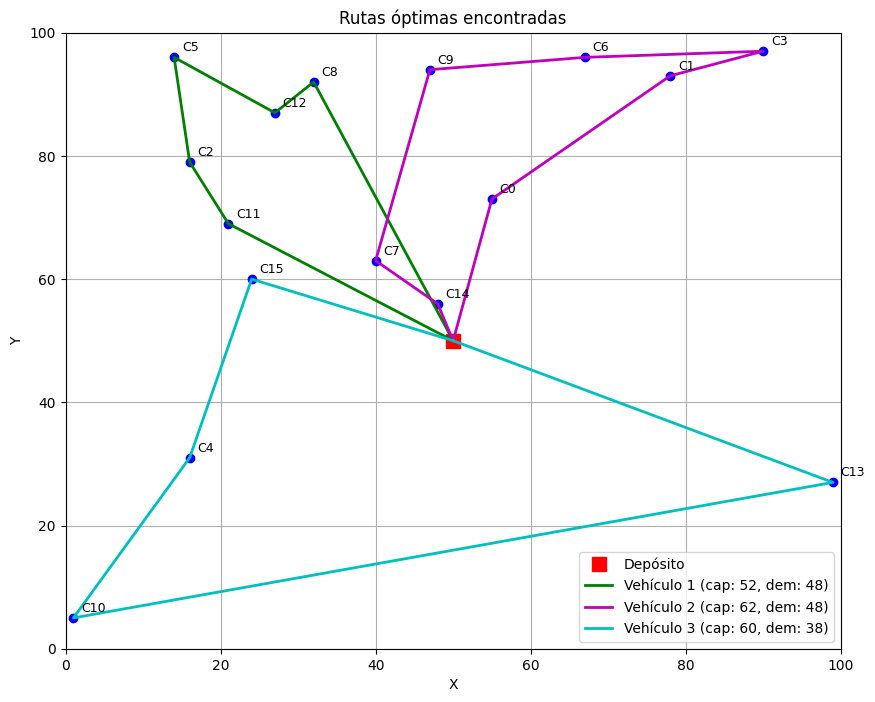

In [62]:
graficar_solucion(mejor, clientes, deposito, vehiculos)

In [63]:
rutas = obtener_rutas_por_vehiculo(mejor, clientes, vehiculos)

demanda_total = sum(cliente.demanda for cliente in clientes)
print(f"Demanda total: {demanda_total}")

capacidad_total = sum(vehiculo.capacidad for vehiculo in vehiculos)
print(f"Capacidad total: {capacidad_total}")

for i, ruta in enumerate(rutas):
    if ruta['vehiculo'] is not None:
        print(f"Vehículo {i + 1} | Capacidad: {ruta['capacidad_total']} | "
              f"Demanda usada: {ruta['demanda_total']} | Clientes: {ruta['clientes']} | "
              f"Distancia total: {ruta['distancia_total']:.2f}")
    else:
        print(f"Clientes no asignados: {ruta['clientes']}")

Demanda total: 134
Capacidad total: 320
Vehículo 1 | Capacidad: 52 | Demanda usada: 48 | Clientes: [11, 2, 5, 12, 8] | Distancia total: 131.54
Vehículo 2 | Capacidad: 62 | Demanda usada: 48 | Clientes: [0, 1, 3, 6, 9, 7, 14] | Distancia total: 158.52
Vehículo 3 | Capacidad: 60 | Demanda usada: 38 | Clientes: [15, 4, 10, 13] | Distancia total: 242.53
Vehículo 4 | Capacidad: 66 | Demanda usada: 0 | Clientes: [] | Distancia total: 0.00
Vehículo 5 | Capacidad: 80 | Demanda usada: 0 | Clientes: [] | Distancia total: 0.00
